
The bengali language, commonly known as bangla is one which is spoken by the people native to the Bengal region of South Asia. It is the sixth most spoken native language and the seventh most spoken language in the world. Machine learning has seen tremendous advancements over the past decade, and one of the most exciting developments in the field is the fusion of quantum computing with traditional neural networks. Quantum computing's ability to process vast amounts of data and perform complex calculations has opened up new possibilities for solving real-world problems. In this post, we shall see how the juxtaposition of machine learning, quantum computing and the bengali language, i.e., my native language plays out.

In this blog, we shall use the bengali MNIST dataset from Kaggle to train a neural network with one convolution layer. But first, let us fetch the data from Kaggle.

In [ ]:
!kaggle datasets download -d truthr/banglamnist

We shall now unzip the dataset for our needs.

In [ ]:
!unzip ./banglamnist.zip

Once done, we shall import necessary libraries. In our case, we shall be using the ```torch``` library to build our neural network. This neural network would have a quantum layer in it which we shall use. This quantum layer is built using the ```qiskit``` library.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary

import qiskit
from qiskit.visualization import *

from PIL import Image

In [ ]:
%matplotlib inline

In [ ]:
torch.__version__

'1.8.1+cu101'

In this notebook, we shall rely on the GPU to speed up the training process for the classical convolution layers. Here we check if the ```CUDA``` is available for use by the ```torch``` library.

In [ ]:
use_cuda = torch.cuda.is_available()

print('CUDA available:', use_cuda)

if use_cuda:
    device = torch.device('cuda')
    print('Training on GPU...')
else:
    device = torch.device('cpu')
    print('Training on CPU...')

CUDA available: True
Training on GPU...


# Data Preprocessing

Our dataset, as it turns out is a bunch of jpg pictures. In order for these images to be readable by the neural network, we shall convert them into image tensors, and associate each tensor with a label from the csv file provided. In this class we build  a ```BanglaMNISTDataset``` class that does exactly that with the using its private functions.



In [ ]:
class BanglaMNISTDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, n_samples=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.n_samples = n_samples

        self.data, self.targets = self._load_data()

        # print(self.img_labels)

    def __len__(self):
        return len(self.targets)

    def _load_data(self):
        data = []
        for idx, row in self.img_labels.iterrows():
          filename, label = row.filename, row.digit
          img = Image.open(os.path.join(self.img_dir, str(filename)))
          if self.transform:
              img = self.transform(img)
          data += [img]
          if self.n_samples:
            if idx >= self.n_samples:
              break
        targets = torch.tensor(self.img_labels['digit'].values.astype(np.float32)[:self.n_samples])
        shape = list(data[0].shape)
        shape[0] = len(data)
        out_data = torch.Tensor(*shape)
        torch.cat(data, out=out_data)

        return out_data, targets

        # return data, targets

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        img_id = self.img_labels.iloc[idx, 1]
        img = Image.open(os.path.join(self.img_dir, img_id))
        label = self.img_labels.iloc[idx, 2]
        # print(img)
        if self.transform:
            image = self.transform(img)
        return (image, label)

In this part, we first transform the image to grayscale, resize the images to dimensions 28 x 28 and then output a tensor.

In [ ]:
trans = transforms.Compose([
                            transforms.Grayscale(),
                            transforms.Resize((28, 28)),
                            transforms.ToTensor()
                            ])

Now once we have achieved that, we shall use labelled data to train the classifier. This is done by making an object of the ```BanglaMNISTDataset``` and using labelled, transformed data.

In [ ]:
n_samples = 1024
batch_size = 64

X_train = BanglaMNISTDataset(annotations_file='labels.csv',
                           img_dir='bangla-mnist/labeled/',
                           transform=trans, n_samples=10000)

X_train.data = X_train.data[:n_samples]
X_train.targets = X_train.targets[:n_samples]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=batch_size, shuffle=True)

To make sure, we did okay, we shall now check the data and make sure they are correctly associated with the labels.

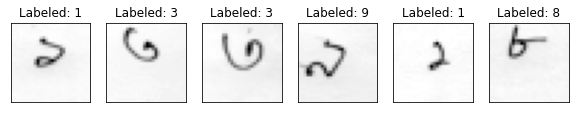

In [ ]:
# check MNIST data

n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

images, targets = data_iter.__next__()


while n_samples_show > 0:
    axes[n_samples_show - 1].imshow(images[n_samples_show].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(int(targets[n_samples_show])))

    n_samples_show -= 1

Now we use the same strategy to see if the test dataset is working correctly



In [ ]:
n_samples = 2048

X_test = BanglaMNISTDataset(annotations_file='labels.csv',
                           img_dir='bangla-mnist/labeled/',
                           transform=trans, n_samples=5000)

X_test.data = X_test.data[:n_samples]
X_test.targets = X_test.targets[:n_samples]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=batch_size, shuffle=True)

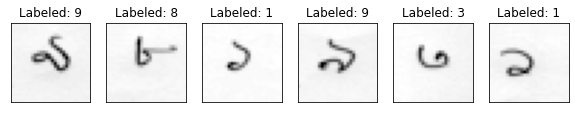

In [ ]:
# check MNIST data

n_samples_show = 6

data_iter = iter(test_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

images, targets = data_iter.__next__()

while n_samples_show > 0:
    axes[n_samples_show - 1].imshow(images[n_samples_show].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(int(targets[n_samples_show])))

    n_samples_show -= 1

## The Quantum Layer

In this layer we shall define our quantum layer. Here we shall work with what is known as a quantum circuit for our logic synthesis. We shall input our data into the quantum layer using the what is known as *angle encoding*, where we use a Hadamard gate, thereby putting it in a state of superposition. Then we embed the features as an angle into the circuit. This will serve as a quantum convolution layer.

In [ ]:
class QuantumCircuit:
    """
    This class provides a simple interface for interaction
    with the quantum circuit
    """

    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)

        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')

        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)

        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots

    def run(self, thetas):
        job = qiskit.execute(self._circuit,
                             self.backend,
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)

        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)

        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)

        return np.array([expectation])

We can measure and visualize the circuit and find the expected value of our embedding.

Expected value for rotation pi 0.55


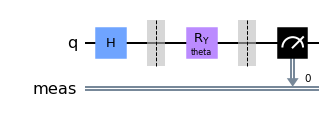

In [ ]:
simulator = qiskit.Aer.get_backend('qasm_simulator')

circuit = QuantumCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw('mpl')

All that is left is to interface the quantum layer with the neural network. In this case, we need to define the forward propagation and backward propagation methodology. We define our automatic differentiation for the backpropagation using the gradients to the expected value of the state post-measurement.

In [ ]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """

    @staticmethod
    def forward(ctx, inputs, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = []
        for input in inputs:
            expectation_z.append(ctx.quantum_circuit.run(input.tolist()))
        result = torch.tensor(expectation_z).cuda()

        ctx.save_for_backward(inputs, result)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())

        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift

        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])

            gradient = torch.tensor([expectation_right]).cuda() - torch.tensor([expectation_left]).cuda()
            gradients.append(gradient)

        # gradients = np.array([gradients]).T
        gradients = torch.tensor([gradients]).cuda()
        gradients = torch.transpose(gradients, 0, 1)

        # return torch.tensor([gradients]).float() * grad_output.float(), None, None
        return gradients.float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """

    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift

    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

Now, all that is left is to piece everything together and build the neural network using everything we have so far. We add 2 convolution layer, a dropout layer and at the end, a 10 qubit hybrid quantum convolution layer.

In [ ]:
class Net(nn.Module):
    def __init__(self, enable_quantum = True):
        super(Net, self).__init__()

        self.enable_quantum = enable_quantum

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 10)
        self.hybrid = [Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2) for i in range(10)]

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.chunk(x, 10, dim=1)
        if self.enable_quantum:
          x = tuple([hy(x_) for hy, x_ in zip(self.hybrid, x)])

        return torch.cat(x, -1)

A summary of the model is given as follows:

In [ ]:
model = Net().cuda()

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
            Conv2d-2             [-1, 16, 8, 8]           2,416
         Dropout2d-3             [-1, 16, 4, 4]               0
            Linear-4                   [-1, 64]          16,448
            Linear-5                   [-1, 10]             650
Total params: 19,670
Trainable params: 19,670
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.08
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


Now we use the ```Adam``` optimizer and a ```CrossEntropyLoss``` to train the model on our dataset. This takes quite a bit of time, even with a GPU.

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = nn.NLLLoss()
loss_func = nn.CrossEntropyLoss().cuda()

epochs = 50
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        data = data.cuda()
        target = target.cuda()

        # Forward pass
        output = model(data).cuda()

        # print("data  ", data.size())
        # print("output", output.size())
        # print("target", target.size())

        # Calculating loss
        loss = loss_func(output, target)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))

## Visualization and Metrics

Now that we have trained the model, we can see visualize how the model minimizes the losses.

Text(0, 0.5, 'Neg Log Likelihood Loss')

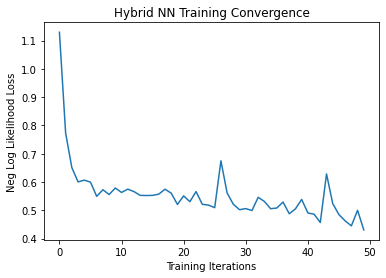

In [ ]:
def show_loss(loss_list):
  plt.plot(loss_list)
  plt.title('Hybrid NN Training Convergence')
  plt.xlabel('Training Iterations')
  plt.ylabel('Neg Log Likelihood Loss')

Let us now see the accuracy of the model.

In [ ]:
def evaluate(model):
  model.eval()
  with torch.no_grad():

    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(test_loader):

        data = data.cuda()
        target = target.cuda()

        output = model(data).cuda()

        pred = output.argmax(dim=1, keepdim=True)

        correct += pred.eq(target.view_as(pred)).sum().item()
        total += len(target)
        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print('Performance on test data:\n\tTotal: {:.4f}\n\tCorrect: {:.4f}\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        total,
        correct,
        sum(total_loss) / len(total_loss),
        (correct / total)*100 )
        )

Performance on test data:
	Total: 2048.0000
	Correct: 1717.0000
	Loss: 0.5187
	Accuracy: 83.8%


Finally, let us see how the model fares in testing. With an accuracy of around 84%, we dont expect a lot.

16


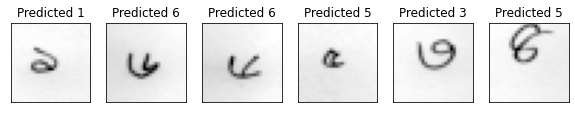

In [ ]:
def test(model):
  n_samples_show = 6
  count = 0
  fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

  model.eval()
  print(len(test_loader))
  with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break

        data_cuda = data.cuda()
        target_cuda = target.cuda()

        output_cuda = model(data_cuda).cuda()

        pred = output_cuda.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[count].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred[count].item()))

        count += 1

In conclusion, we can see that in this case, the quantum layer does not improve the performance by any stretch. This is due to several reasons: There is information loss whenever there we try any kind of embedding technique from classical to quantum data. This could be improved with the introduction of transfer learning but a quantum layer, in this case, does nothing but bring down the accuracy of a model.